In [1]:
import torch
import torch.nn as nn
from print_util import *
import models
from utils import *
from utils_pipeline1 import *

In [2]:
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

# Deep Learning Project 1 Experiences

_The goal of this project is to, given the images of two digits (14 x 14), predict which is one is bigger._

_In order to tackle this problem we decided to try different architectures and techniques. Here is our roadmap:_


### _1. Treat the inputs (2 images) like two dependent channels_
- _A. Network with 2 convolutionnal layers_
- _B. Network with 3 convolutionnal layers_
    - _without the use of an auxiliary loss_
    - _with the use of an auxialiry loss (similar to the one used in GoogLeNet) having the same objective as the primary loss_
- _C. Network with 4 convolutionnal layers_
    - _without the use of an auxiliary loss_
    - _with the use of an auxialiry loss (similar to the one used in GoogLeNet) having the same objective as the primary loss_

### 2. Treat the inputs as two independent images (Siamese network)
The two input channels are separated and given as input to a digit prediction network. The model then has a linear layer that predicts which digit is greater than the other, and outputs this result. The learning is made both off the digit prediction part (using the class labels) and off the comparison part (using the target labels). A factor alpha is used to determine what proportion of the loss the digit prediction part should account for.
This method combines weight sharing (the two input channels will go through the same digit prediction network) and auxilliary loss (the loss is computed both at the output and one layer before the output). 
This auxilliary loss is more straightforward than the GoogLeNet one, because we directly have the class labels, and it shows great improvement of the final accuracy (because this time we can use the class labels data). However that loss can only be computed just after the digit is predicted, so most likely one layer before the end of the network. For that reason it is expected to have about the same effect on deep and shallow networks.

- _A. Different ways to separate the learning of the subproblems_
- _B. Testing different depths_

_We will now present the result of all our experiments in this notebook. For better understanding of our pipeline, have a look at the dedicated notebooks._

## Global parameters

In [3]:
BATCH_SIZE = 64
nb_rounds = 10

## Generate data and normalize it

In [4]:
train_input, train_target, train_classes, test_input, test_target, test_classes = generate_data_device(1000, device=device)

In [5]:
train_input = normalize_data(train_input)
test_input = normalize_data(test_input)

In [6]:
print("Training set mean = {a}".format(a = train_input.mean().item()))
print("Training set std = {s}\n".format(s = train_input.std().item()))
print("Test set mean = {a}".format(a = test_input.mean().item()))
print("Test set std = {s}".format(s = test_input.std().item()))

Training set mean = -1.1463554550061872e-08
Training set std = 1.0

Test set mean = 2.992591134898248e-07
Test set std = 0.9999999403953552


## 1. Treat the inputs (2 images) like two dependent channels

### A. Network with 2 convolutionnal layers

In [7]:
network_class_1 = models.BaselineNetwork
network_1 = network_class_1().to(device=device)
print(network_1)

BaselineNetwork(
  (conv1): Conv2d(2, 32, kernel_size=(2, 2), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


_We chose the optimizer parameter that gave us the best results overall and ensured convergence._ 

In [8]:
train_accuracies_1, train_losses_1, test_accuracies_1, test_losses_1 = train_model(network_1,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           100, 
                                                                           BATCH_SIZE, 
                                                                           {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97}, 
                                                                           logging = True,
                                                                           )

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[100/100]   42s     0.0007         100.0000            24.1907        80.6000             


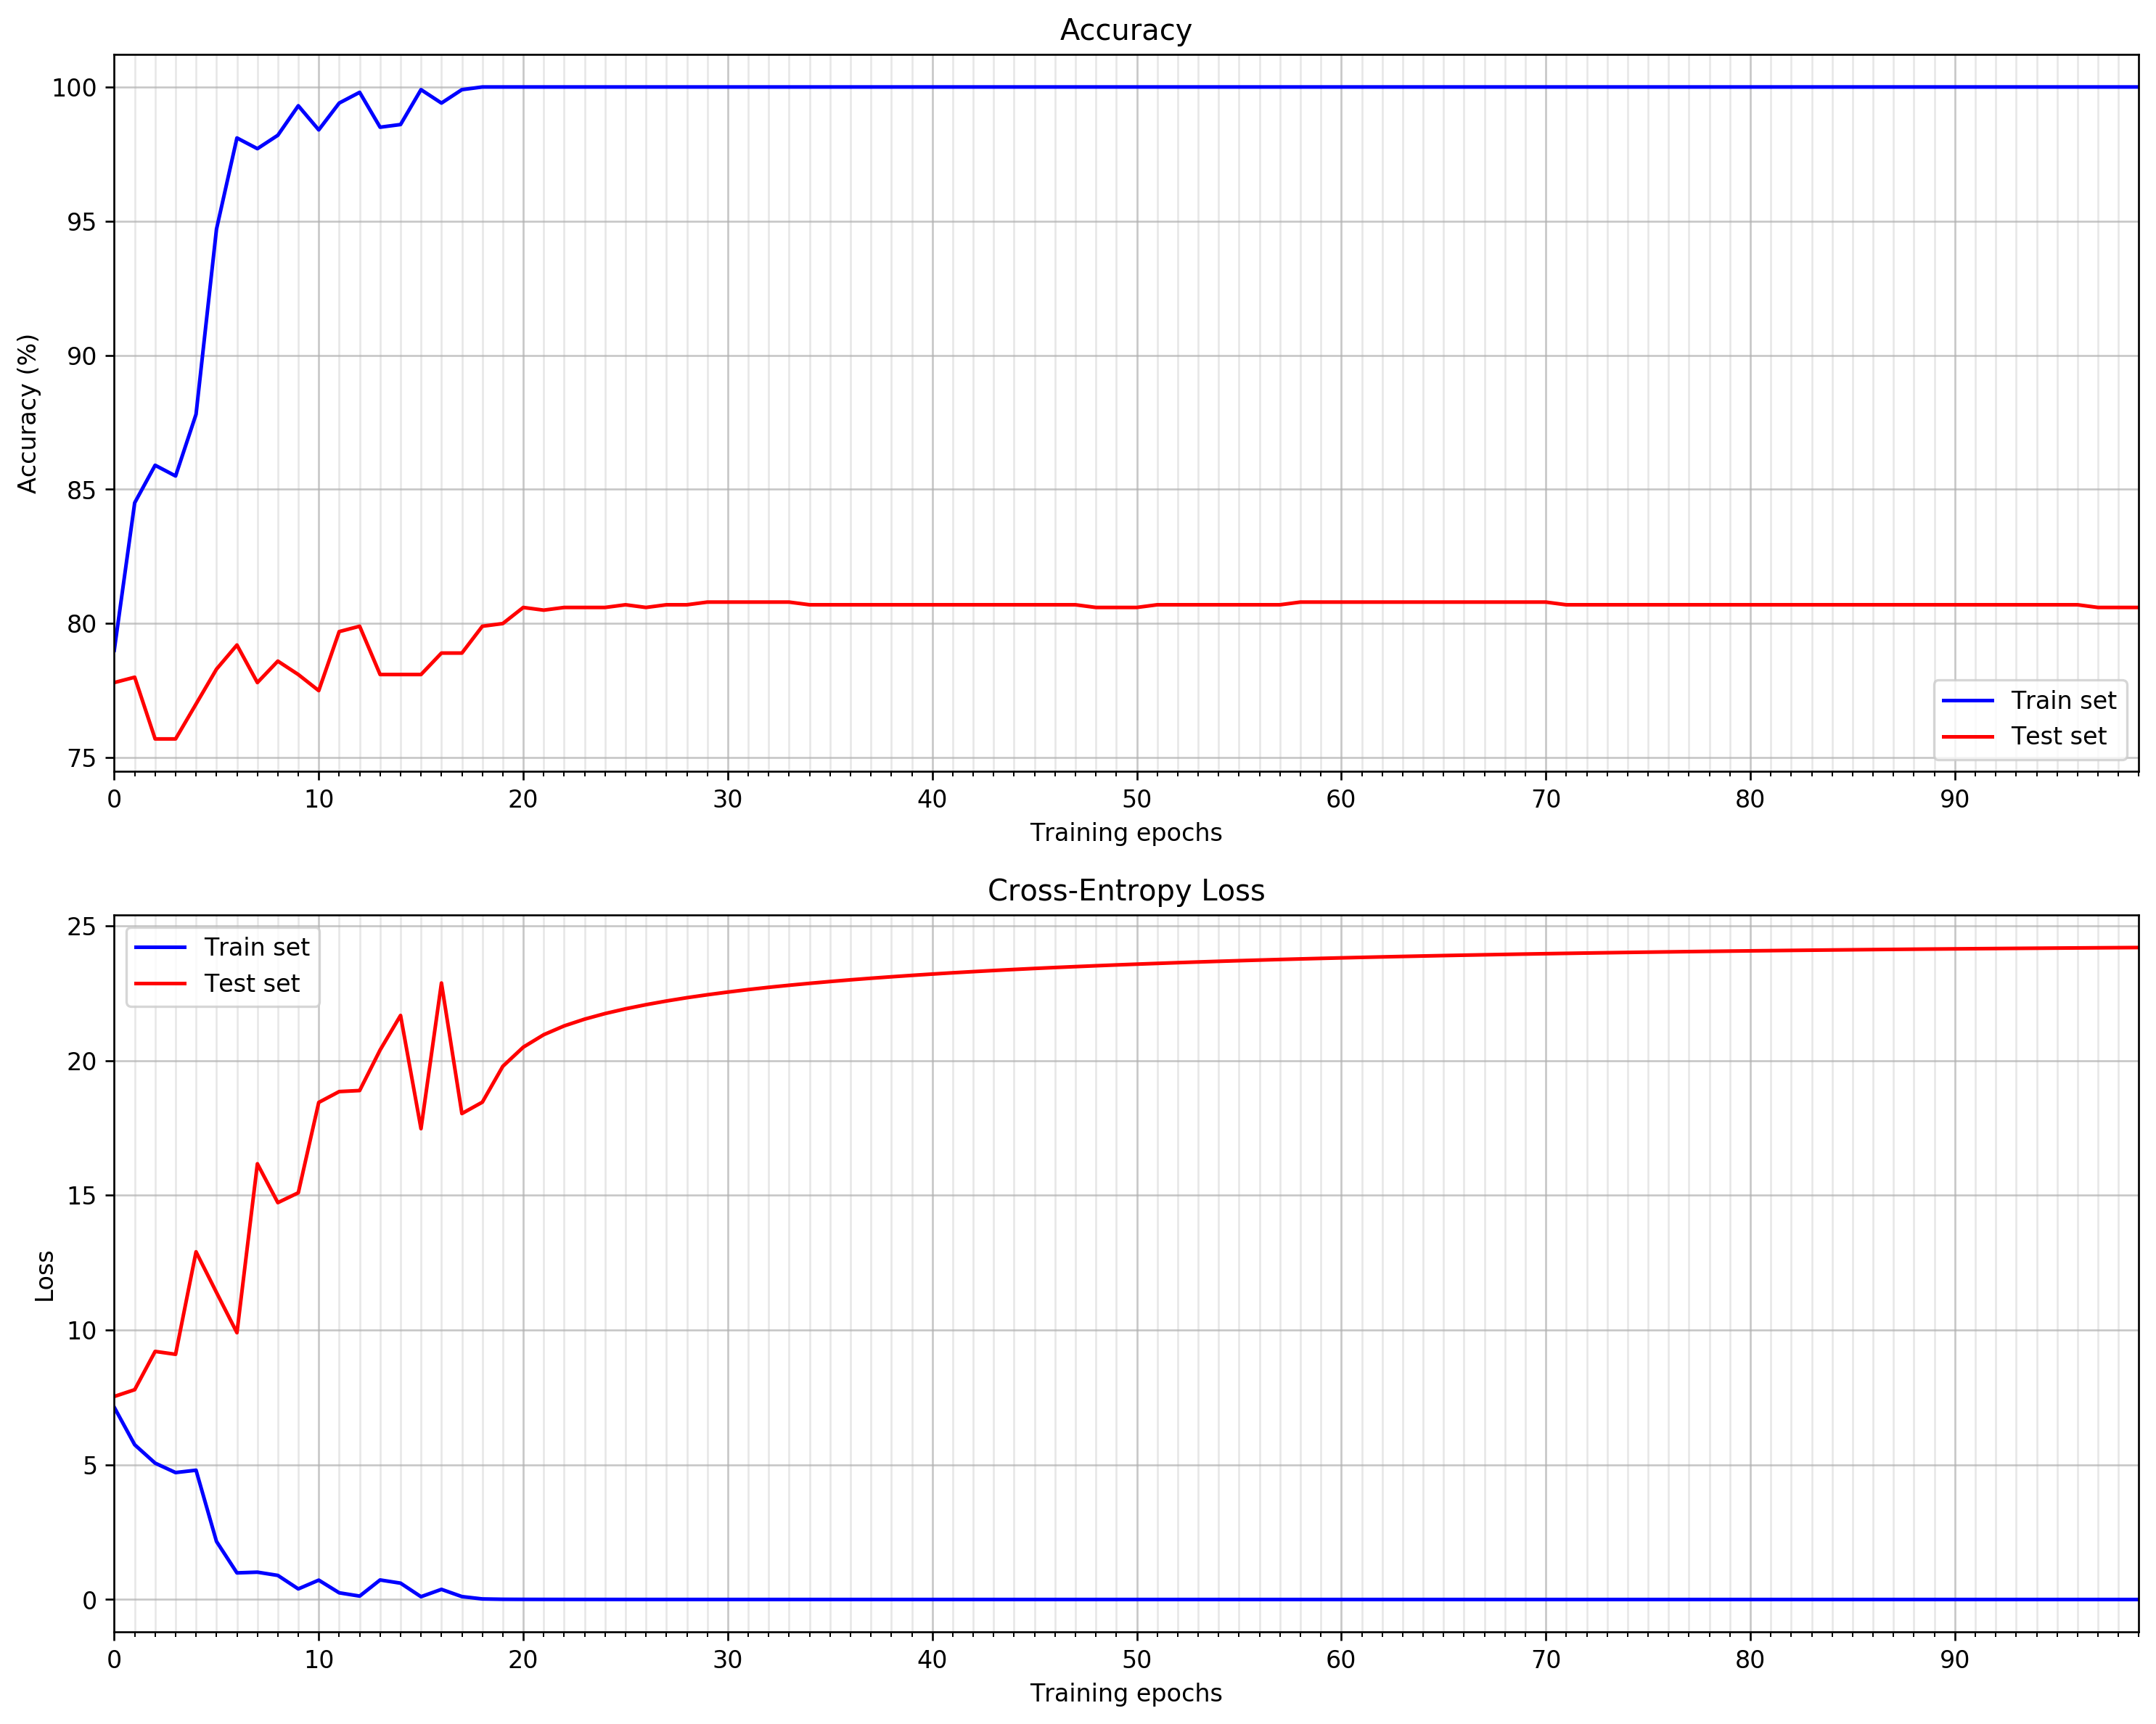

In [9]:
plot_acc_loss(train_accuracies_1, train_losses_1, test_accuracies_1, test_losses_1)

_We now evaluate our model to obtain a mean accuracy as well as the accuracy standard deviation._

_As can be see, the model converges after ~30 epochs._

# TODO: Change nb of epochs later

In [8]:
accuracies_1 = evaluate_model(network_class_1, nb_rounds, nn.CrossEntropyLoss(), device, BATCH_SIZE, 40, {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97})

Round 1: accuracy = 77.30% | loss = 29.1302
Round 2: accuracy = 45.10% | loss = nan
Round 3: accuracy = 77.90% | loss = 23.5485
Round 4: accuracy = 55.60% | loss = 10.9888
Round 5: accuracy = 42.90% | loss = nan
Round 6: accuracy = 81.20% | loss = 25.1072
Round 7: accuracy = 78.60% | loss = 29.2535
Round 8: accuracy = 46.20% | loss = nan
Round 9: accuracy = 44.90% | loss = nan
Round 10: accuracy = 80.60% | loss = 20.7276


In [9]:
print("The mean accuracy is: {a:0.2f}".format(a = accuracies_1.mean()))
print("The accuracy std is: {s:0.4f}".format(s = accuracies_1.std()))

The mean accuracy is: 63.03
The accuracy std is: 17.3201


### B. Network with 3 convolutionnal layers
#### 1. without the use of an auxiliary loss

In [10]:
network_class_2 = models.Net2
network_2 = network_class_2(aux_loss = False).to(device=device)
print(network_2)

Net2(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [11]:
train_accuracies_2, train_losses_2, test_accuracies_2, test_losses_2 = train_model(network_2,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           100, 
                                                                           BATCH_SIZE, 
                                                                           {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97}, 
                                                                           logging = True,
                                                                           )

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[100/100]   121s    5.2715         98.4000             7.8147         81.5000             


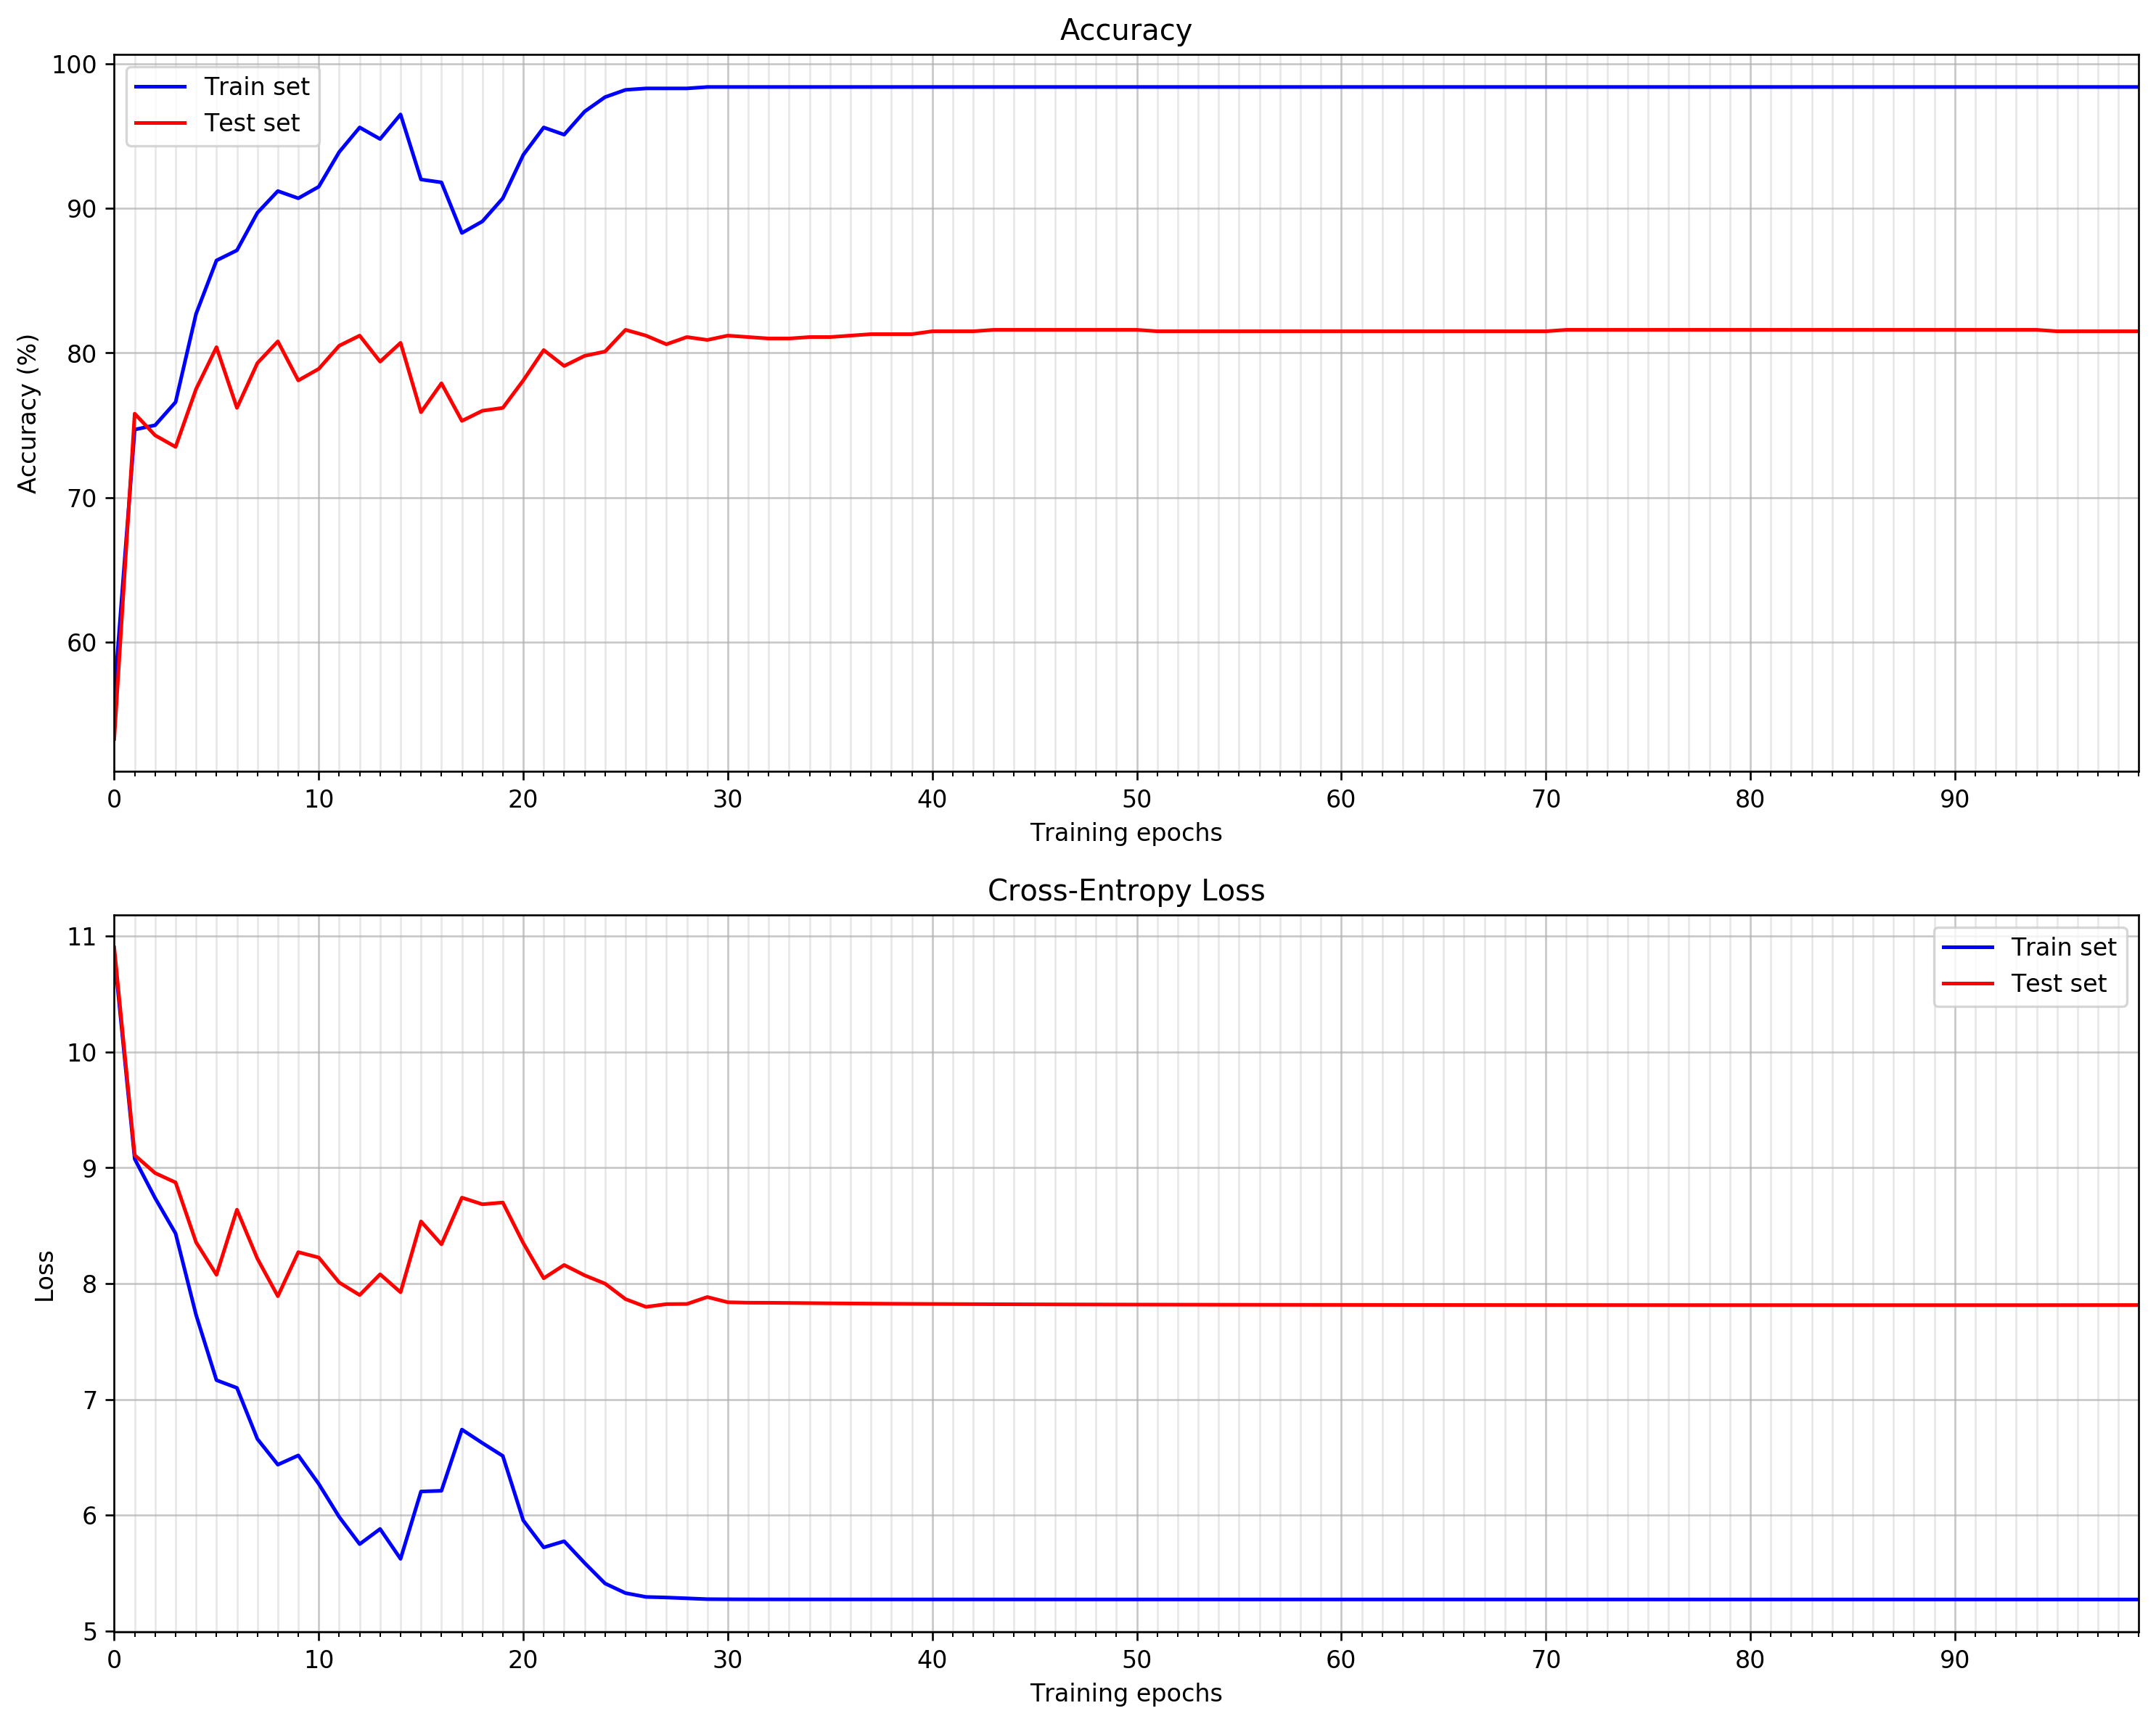

In [12]:
plot_acc_loss(train_accuracies_2, train_losses_2, test_accuracies_2, test_losses_2)

# TODO: change nb_epoch to 100 later

In [13]:
accuracies_2 = evaluate_model(network_class_2, nb_rounds, nn.CrossEntropyLoss(), device, BATCH_SIZE, 20, {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97})

Round 1: accuracy = 82.00% | loss = 7.8557
Round 2: accuracy = 76.00% | loss = 8.6388
Round 3: accuracy = 78.40% | loss = 8.2491
Round 4: accuracy = 81.30% | loss = 7.8699
Round 5: accuracy = 80.50% | loss = 8.0895
Round 6: accuracy = 78.20% | loss = 8.3723
Round 7: accuracy = 83.20% | loss = 7.6647
Round 8: accuracy = 82.00% | loss = 7.7546
Round 9: accuracy = 77.90% | loss = 8.3833
Round 10: accuracy = 81.00% | loss = 7.8469


In [14]:
print("The mean accuracy is: {a:0.2f}".format(a = accuracies_2.mean()))
print("The accuracy std is: {s:0.4f}".format(s = accuracies_2.std()))

The mean accuracy is: 80.05
The accuracy std is: 2.2941


#### 2. with the use of an auxialiry loss (similar to the one used in GoogLeNet) having the same objective as the primary loss

In [15]:
network_2_aux_loss = network_class_2(aux_loss = True).to(device=device)
print(network_2_aux_loss)

Net2(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc1_aux): Linear(in_features=1600, out_features=128, bias=True)
  (fc2_aux): Linear(in_features=128, out_features=2, bias=True)
)


_This time an auxiliary loss is used for training._

In [16]:
train_accuracies_2_aux, train_losses_2_aux, test_accuracies_2_aux, test_losses_2_aux = train_model(network_2_aux_loss,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           100, 
                                                                           BATCH_SIZE, 
                                                                           {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97}, 
                                                                           logging = True,
                                                                           with_aux_loss = True)

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[100/100]   134s    7.9015         98.5000             11.4077        83.1000             


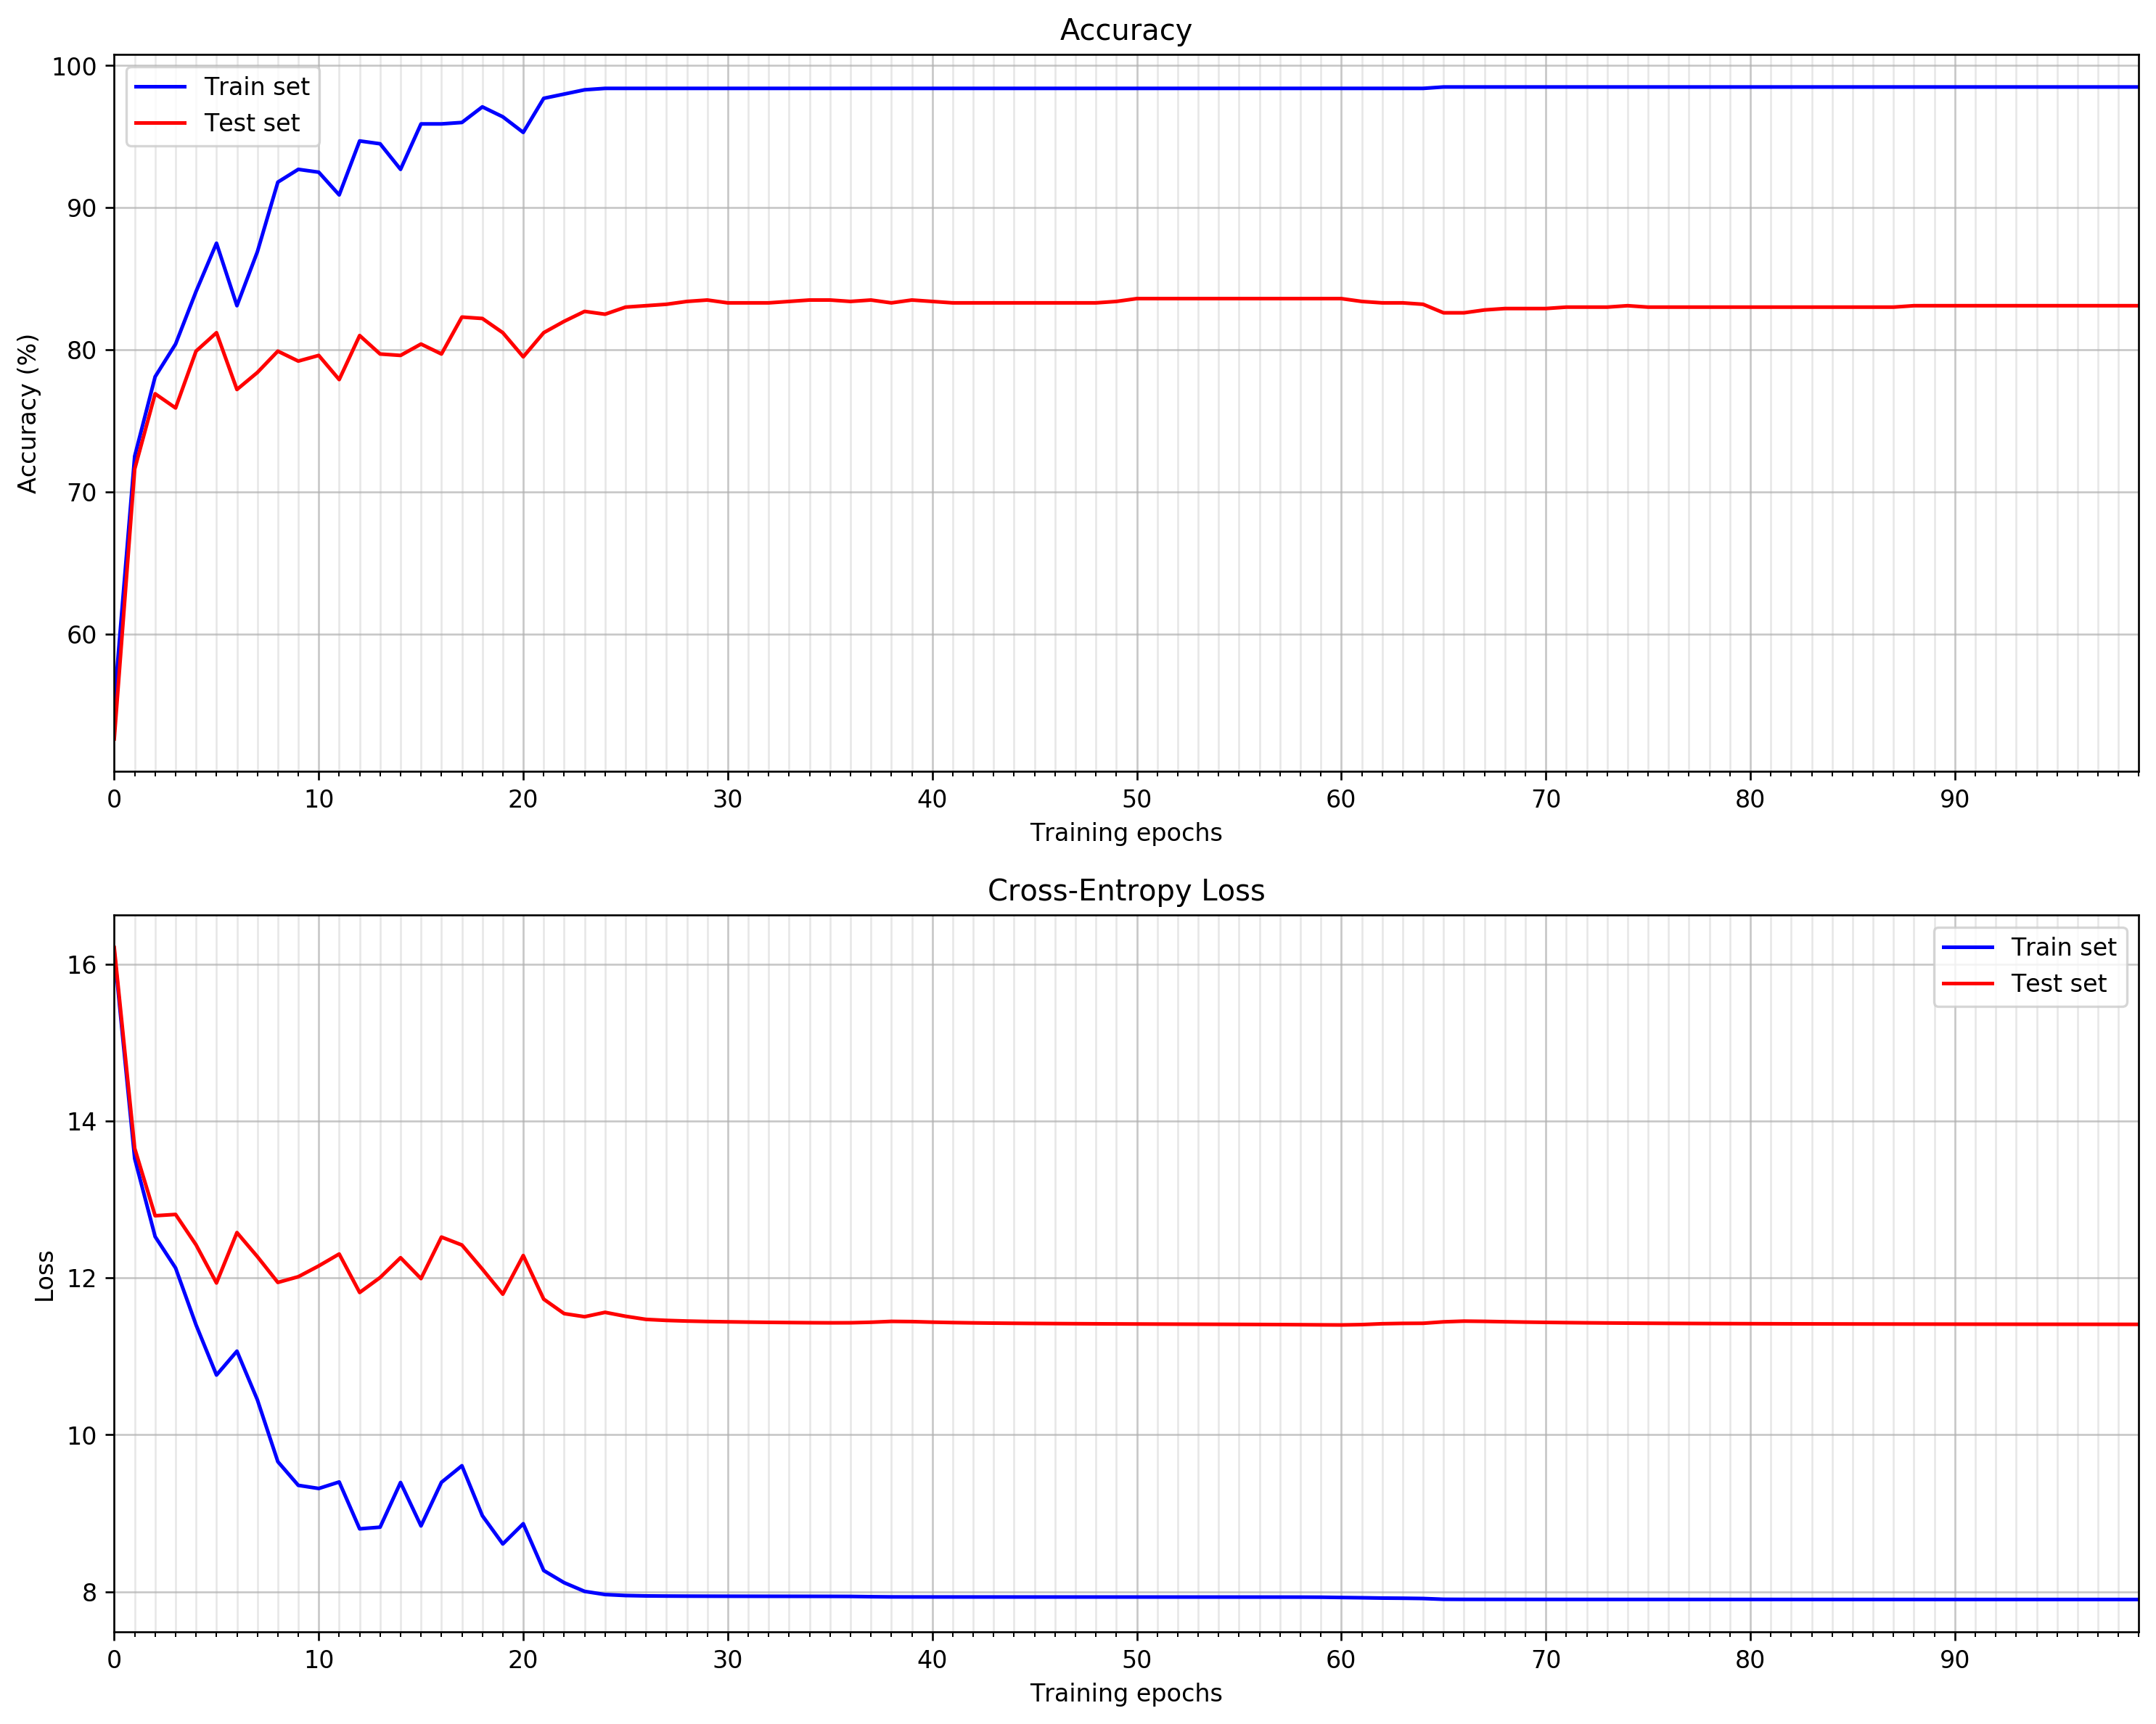

In [17]:
plot_acc_loss(train_accuracies_2_aux, train_losses_2_aux, test_accuracies_2_aux, test_losses_2_aux)

_Because we now have an hyperparameter (aux_loss_alpha), we will tune it using cross validation._

# TODO: Tune it on GPU with bigger K and nb of epochs and more alphas

In [18]:
best_alpha_1, best_accuracy_1 = cross_validation(network_class_2,
                                             3,
                                             train_input,
                                             train_target,
                                             train_classes,
                                             device,
                                             BATCH_SIZE,
                                             30,
                                             [0.1, 0.3, 0.5])

aux_loss_alpha = 0.1 - mean accuracy = 80.83333333333333
aux_loss_alpha = 0.3 - mean accuracy = 81.5
aux_loss_alpha = 0.5 - mean accuracy = 82.16666666666667


In [19]:
print("The best aux_loss_alpha is: {a}".format(a = best_alpha_1))

The best aux_loss_alpha is: 0.5


# TODO: Evaluate on more epochs with GPU

In [20]:
accuracies_2_aux = evaluate_model(network_class_2,
                                    nb_rounds,
                                    nn.CrossEntropyLoss(),
                                    device, BATCH_SIZE,
                                    30,
                                    {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97},
                                    {'aux_loss': True},
                                    with_aux_loss = True,
                                    aux_loss_alpha = best_alpha_1)

Round 1: accuracy = 80.60% | loss = 11.7784
Round 2: accuracy = 80.00% | loss = 12.0669
Round 3: accuracy = 84.30% | loss = 11.3329
Round 4: accuracy = 81.30% | loss = 11.7334
Round 5: accuracy = 83.50% | loss = 11.3424
Round 6: accuracy = 80.60% | loss = 11.9081
Round 7: accuracy = 83.60% | loss = 11.2140
Round 8: accuracy = 82.90% | loss = 11.4101
Round 9: accuracy = 82.00% | loss = 11.5647
Round 10: accuracy = 83.30% | loss = 11.4949


In [21]:
print("The mean accuracy is: {a:0.2f}".format(a = accuracies_2_aux.mean()))
print("The accuracy std is: {s:0.4f}".format(s = accuracies_2_aux.std()))

The mean accuracy is: 82.21
The accuracy std is: 1.5118


### C. Network with 4 convolutionnal layers
#### 1. without the use of an auxiliary loss

In [22]:
network_class_3 = models.Net3
network_3 = network_class_3(aux_loss = False).to(device=device)
print(network_3)

Net3(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [23]:
train_accuracies_3, train_losses_3, test_accuracies_3, test_losses_3 = train_model(network_3,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           100, 
                                                                           BATCH_SIZE, 
                                                                           {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97}, 
                                                                           logging = True,
                                                                           )

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[100/100]   92s     5.5380         96.7000             7.9817         80.3000             


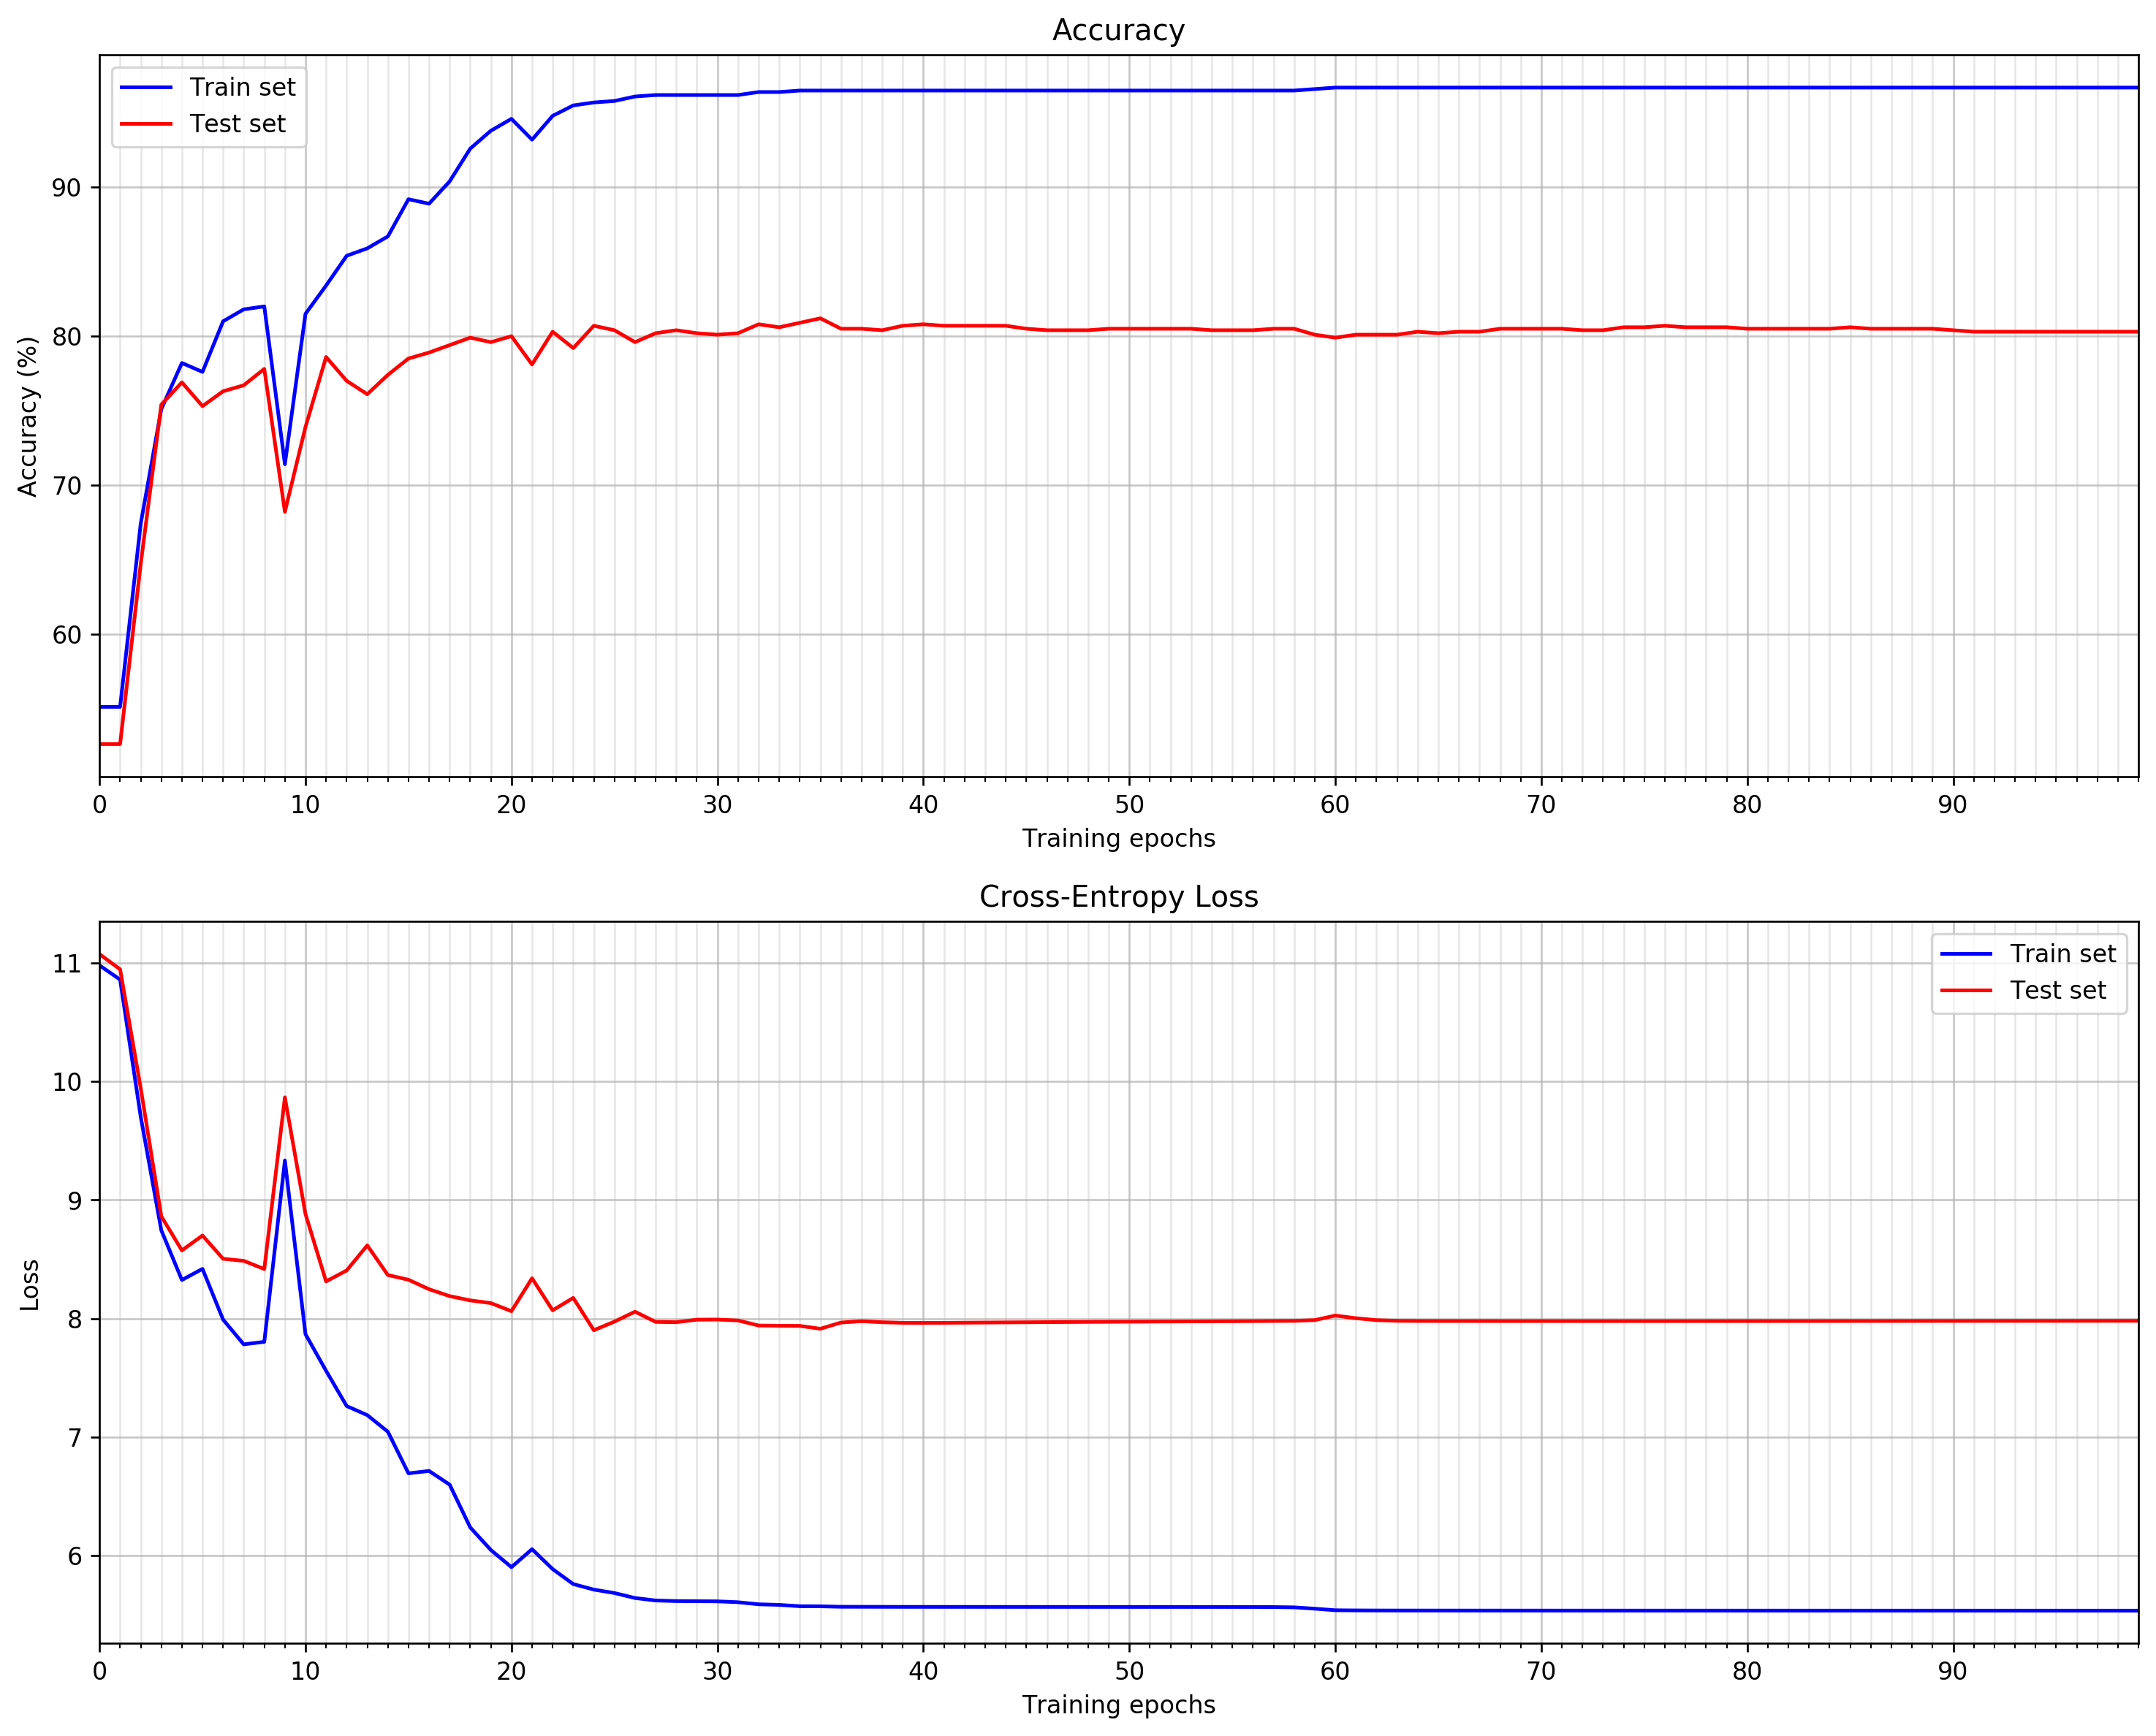

In [24]:
plot_acc_loss(train_accuracies_3, train_losses_3, test_accuracies_3, test_losses_3)

# TODO: Change to bigger nb of epoch later

In [25]:
accuracies_3 = evaluate_model(network_class_3, nb_rounds, nn.CrossEntropyLoss(), device, BATCH_SIZE, 20, {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97})

Round 1: accuracy = 80.20% | loss = 8.0398
Round 2: accuracy = 73.70% | loss = 9.0280
Round 3: accuracy = 76.60% | loss = 8.5282
Round 4: accuracy = 77.00% | loss = 8.5681
Round 5: accuracy = 74.90% | loss = 8.8026
Round 6: accuracy = 77.10% | loss = 8.4662
Round 7: accuracy = 79.50% | loss = 8.2179
Round 8: accuracy = 79.70% | loss = 8.1107
Round 9: accuracy = 78.80% | loss = 8.2225
Round 10: accuracy = 78.80% | loss = 8.2069


In [26]:
print("The mean accuracy is: {a:0.2f}".format(a = accuracies_3.mean()))
print("The accuracy std is: {s:0.4f}".format(s = accuracies_3.std()))

The mean accuracy is: 77.63
The accuracy std is: 2.1541


#### 2. with the use of an auxialiry loss (similar to the one used in GoogLeNet) having the same objective as the primary loss

In [27]:
network_3_aux_loss = network_class_3(aux_loss = True).to(device=device)
print(network_3_aux_loss)

Net3(
  (conv1): Conv2d(2, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=1152, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (fc1_aux): Linear(in_features=800, out_features=128, bias=True)
  (fc2_aux): Linear(in_features=128, out_features=2, bias=True)
)


In [28]:
train_accuracies_3_aux, train_losses_3_aux, test_accuracies_3_aux, test_losses_3_aux = train_model(network_3_aux_loss,
                                                                           train_input, 
                                                                           train_target, 
                                                                           train_classes, 
                                                                           test_input, 
                                                                           test_target, 
                                                                           test_classes, 
                                                                           100, 
                                                                           BATCH_SIZE, 
                                                                           {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97}, 
                                                                           logging = True,
                                                                           with_aux_loss = True)

Epoch       Time    Train loss     Train accuracy      Test loss      Test accuracy       
[100/100]   102s    7.9688         98.1000             11.6132        81.9000             


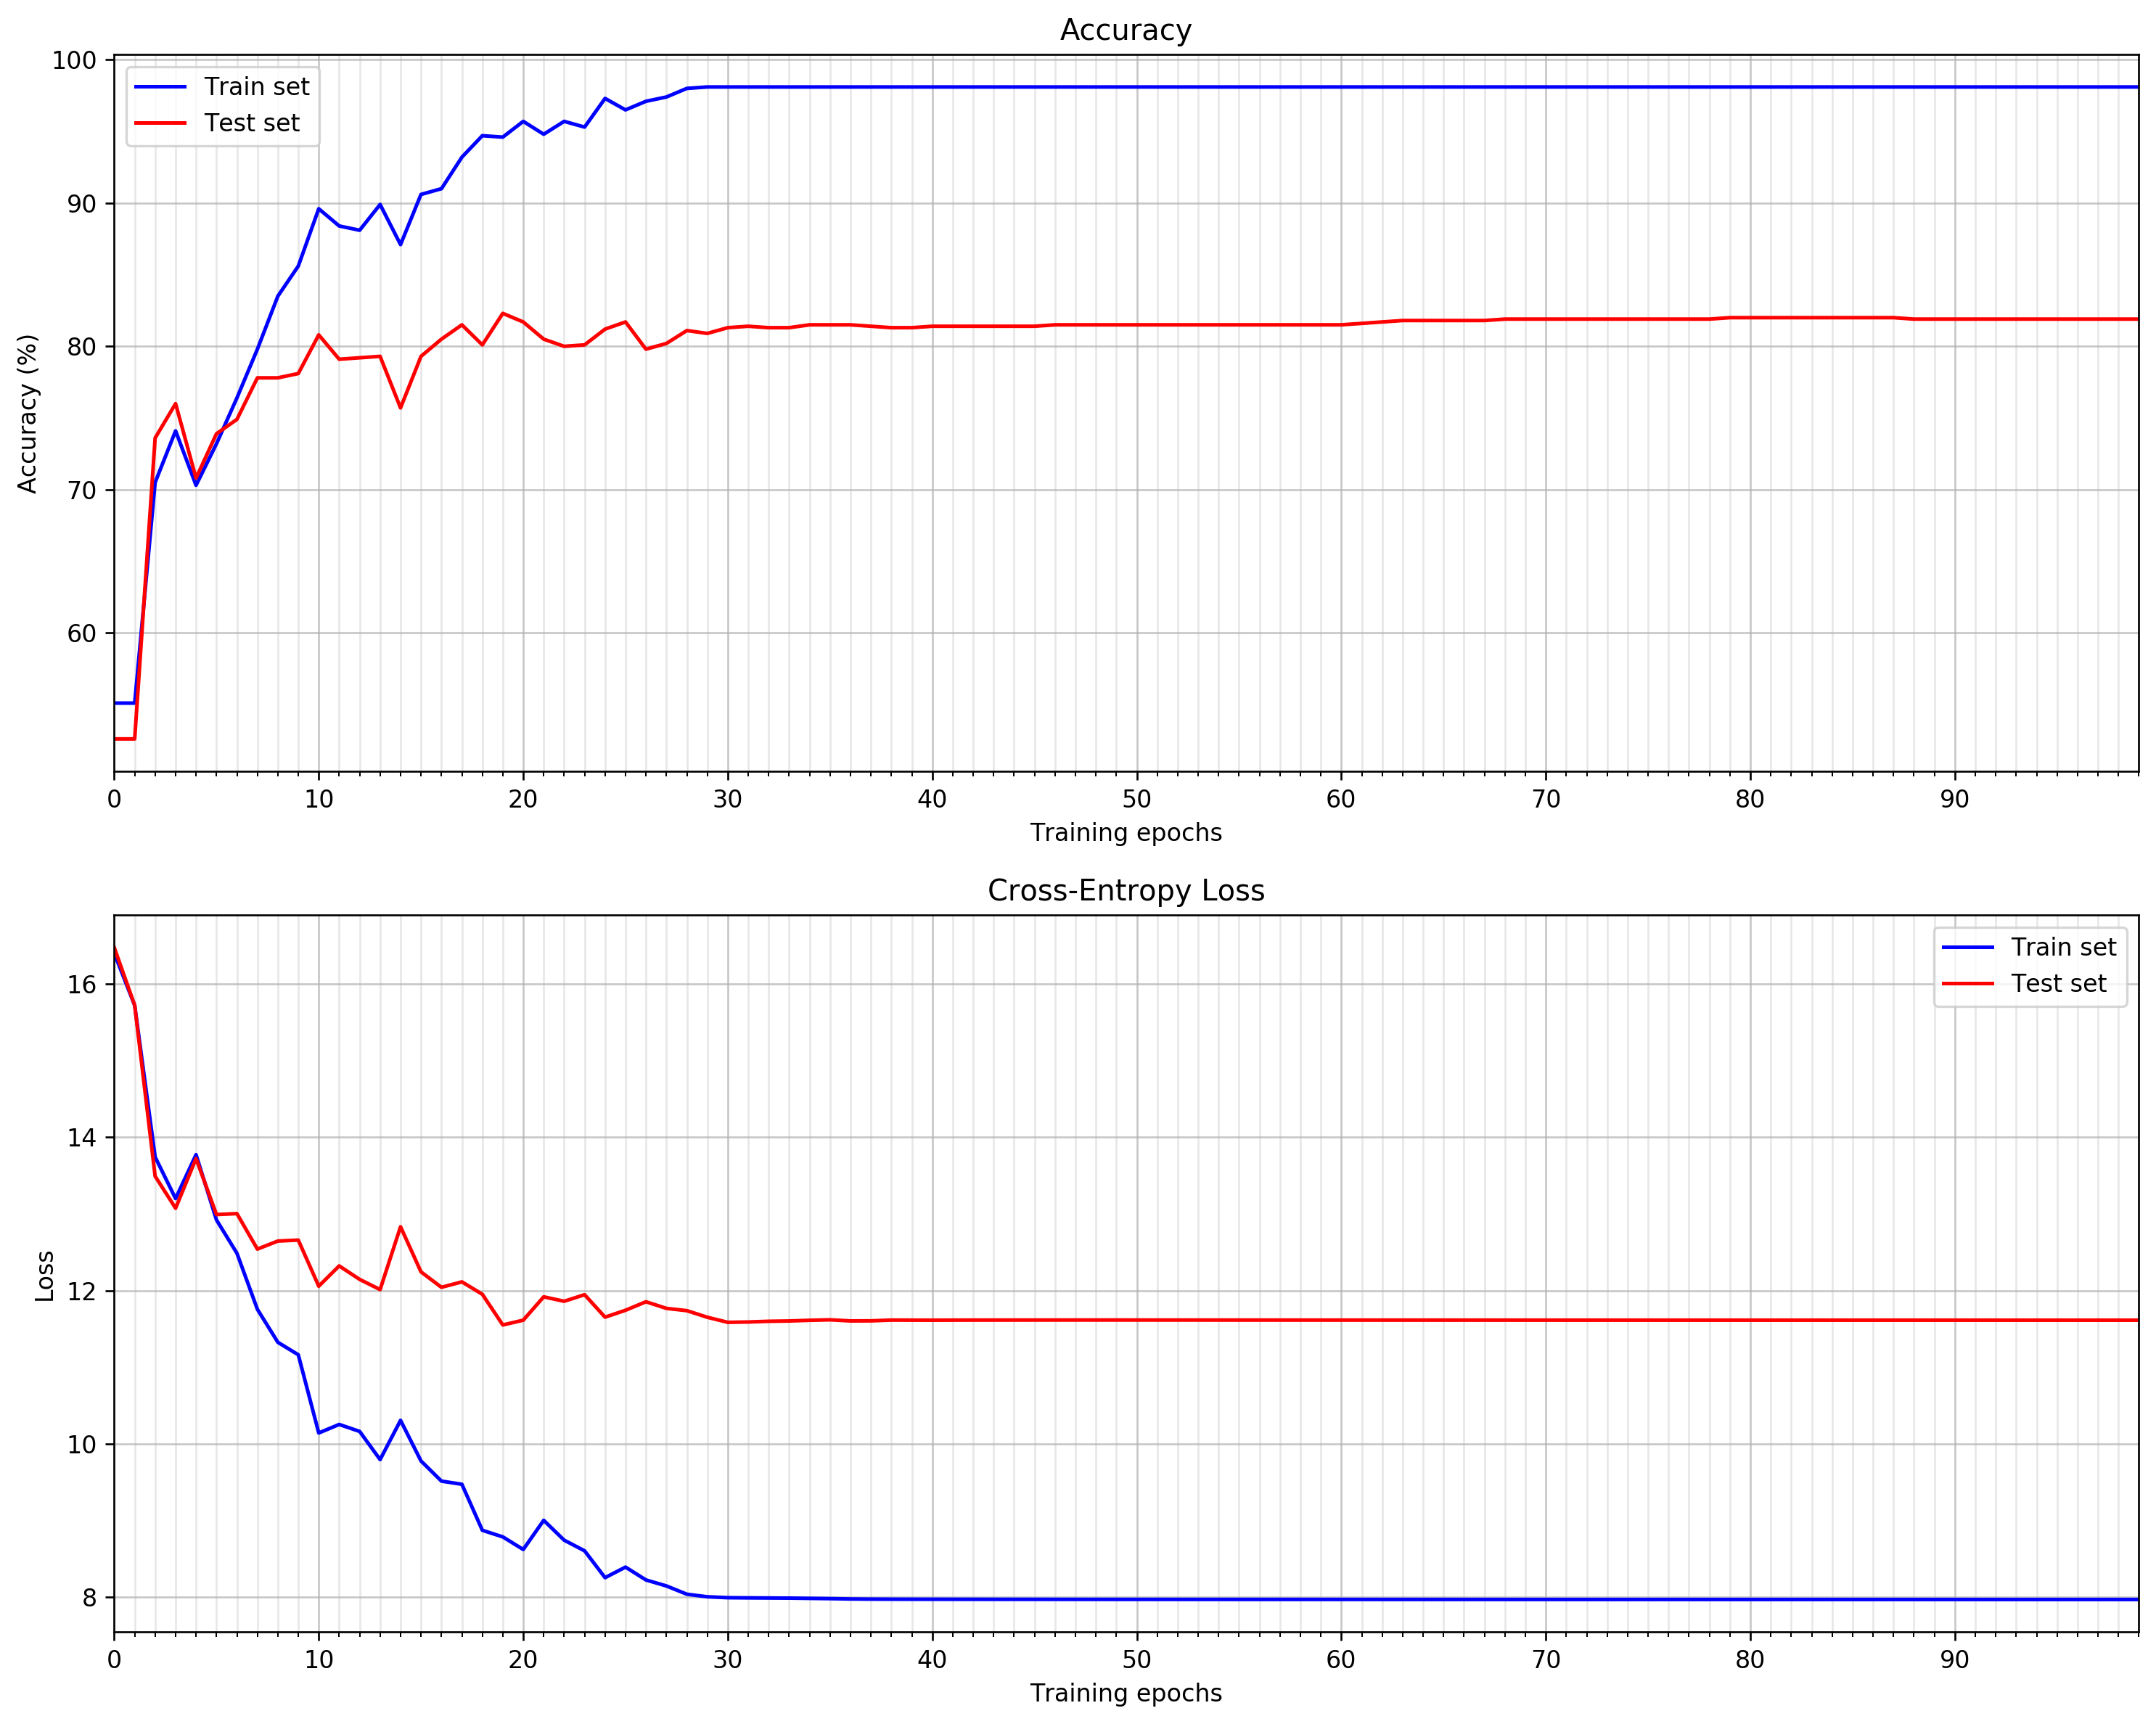

In [29]:
plot_acc_loss(train_accuracies_3_aux, train_losses_3_aux, test_accuracies_3_aux, test_losses_3_aux)

# TODO: Tune on GPU with bigger K and nb of epochs and more alphas

In [30]:
best_alpha_2, best_accuracy_2 = cross_validation(network_class_3,
                                             3,
                                             train_input,
                                             train_target,
                                             train_classes,
                                             device,
                                             BATCH_SIZE,
                                             30,
                                             [0.1, 0.3, 0.5])

aux_loss_alpha = 0.1 - mean accuracy = 77.33333333333333
aux_loss_alpha = 0.3 - mean accuracy = 80.83333333333333
aux_loss_alpha = 0.5 - mean accuracy = 78.0


In [31]:
print("The best aux_loss_alpha is: {a}".format(a = best_alpha_2))

The best aux_loss_alpha is: 0.3


# TODO: Do with a bigger nb of epochs

In [32]:
accuracies_3_aux = evaluate_model(network_class_3,
                                    nb_rounds,
                                    nn.CrossEntropyLoss(),
                                    device, BATCH_SIZE,
                                    30,
                                    {'lr': 0.1, 'momentum':0.9, 'weight_decay': 0.0, 'gamma': 0.97},
                                    {'aux_loss': True},
                                    with_aux_loss = True,
                                    aux_loss_alpha = best_alpha_2)

Round 1: accuracy = 79.60% | loss = 10.5422
Round 2: accuracy = 80.30% | loss = 10.3030
Round 3: accuracy = 80.10% | loss = 10.5468
Round 4: accuracy = 81.40% | loss = 10.1606
Round 5: accuracy = 80.80% | loss = 10.4013
Round 6: accuracy = 79.90% | loss = 10.4121
Round 7: accuracy = 83.80% | loss = 9.8489
Round 8: accuracy = 80.10% | loss = 10.4196
Round 9: accuracy = 81.10% | loss = 10.3292
Round 10: accuracy = 79.00% | loss = 10.6705


In [33]:
print("The mean accuracy is: {a:0.2f}".format(a = accuracies_3_aux.mean()))
print("The accuracy std is: {s:0.4f}".format(s = accuracies_3_aux.std()))

The mean accuracy is: 80.61
The accuracy std is: 1.3254


## 2. Siamese Network

### A. Different ways to separate the learning of the subproblems

We tried 3 different approaches:
- Approach 1: first learning only the digit prediction part of the network (using the auxilliary loss) and then freezing the digit prediction part and learning the comparison part.
- Approach 2: same as approach 1 but keep learning the digit prediction part while learning the comparison part (no freezing)
- Approach 3: learning everything together